<a href="https://colab.research.google.com/github/zhangchenbocalvin/city-search-tool/blob/main/city_search_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import random
import io
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

### Load data

In [10]:
cities_ds = pd.read_csv('https://raw.githubusercontent.com/zhangchenbocalvin/city-search-tool/main/data/cities_ds.csv')
people_ds = pd.read_csv('https://raw.githubusercontent.com/zhangchenbocalvin/city-search-tool/main/data/people_ds_100.csv')
people = people_ds['Weights'].str.replace('(', '', regex=True).str.replace(')', '', regex=True).str.replace(',', '', regex=True).str.split(expand=True)

people.head()

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,2
3,0,0,0,0,0,3
4,0,0,0,0,1,0


### Add your preferences about Purchase Power, Health Care, Pollution, QoL_H, Crime Rating and UNESCO

In [15]:
# 0 = none, 1 = low, 2 = mid, 3 = high
df = pd.DataFrame([1, 1, 0, 1, 1, 1]).T
df

,0,1,2,3,4,5
0,1,1,0,1,1,1


### Compute the most similar people to you

In [16]:
people_ds['md'] = pd.DataFrame(manhattan_distances(df, people)).T

In [17]:
topk_people = pd.DataFrame(people_ds.sort_values('md').head(20)['City'].unique(),columns={'City'})

In [18]:
topk_people

,City
0,Dresden
1,Lausanne
2,Munich
3,Aachen
4,Basel
5,Ottawa


### Compute the top K cities

In [19]:
topk_people_city = pd.merge(topk_people['City'],
                            cities_ds[['City','Purchase Power', 'Health Care', 'Pollution', 'QoL_H', 'Crime Rating', 'Unesco']],
                            on='City')
topk_people_city

,City,Purchase Power,Health Care,Pollution,QoL_H,Crime Rating,Unesco
0,Dresden,89.177489,76.480767,18.275265,89.225212,5.986104,18.181818
1,Lausanne,98.736399,59.922800,94.806319,85.321065,32.990379,54.545455
2,Munich,66.573067,89.977373,46.613287,89.151146,5.986104,18.181818
3,Aachen,63.378963,69.772395,12.648777,89.401830,5.986104,27.272727
4,Basel,83.994384,78.410755,64.033759,93.901284,23.062533,27.272727
5,Ottawa,100.000000,60.149075,36.301666,90.311393,15.219134,9.090909


In [20]:
topk_city = pd.DataFrame(euclidean_distances(topk_people_city[['Purchase Power', 'Health Care', 'Pollution', 'QoL_H', 'Crime Rating', 'Unesco']],
                                             cities_ds[['Purchase Power', 'Health Care', 'Pollution', 'QoL_H', 'Crime Rating', 'Unesco']])).T
topk_city['mean'] = topk_city.mean(axis=1)

city_Score = pd.concat([cities_ds['City'], topk_city['mean']], axis=1)
city_Score.sort_values('mean').head(10)

,City,mean
91,Basel,38.982813
182,Dresden,39.713519
183,Munich,40.067243
118,Ottawa,40.809260
180,Stuttgart,43.034372
191,Dubai,45.206741
193,Luxembourg,45.540771
181,Aachen,45.858993
79,Leicester,46.938455
179,Berlin,46.975854


In [21]:
print(city_Score.sort_values('mean')["City"][:10])

91          Basel
182       Dresden
183        Munich
118        Ottawa
180     Stuttgart
191         Dubai
193    Luxembourg
181        Aachen
79      Leicester
179        Berlin
Name: City, dtype: object


### Visualization through dimensionality reduction

In [22]:
df = cities_ds

rndperm = np.random.permutation(df.shape[0])
df_subset = df.loc[rndperm,:].copy()
data_subset = df_subset[['Purchase Power', 'Health Care', 'Pollution', 'Crime Rating', 'Unesco', 'QoL_H']].values

tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=800)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 197 samples in 0.032s...
[t-SNE] Computed neighbors for 197 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 7.521101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.299873
[t-SNE] KL divergence after 800 iterations: 0.586070


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

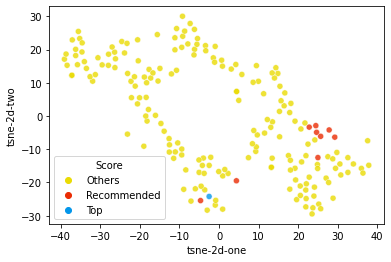

In [31]:
new_dataframe = df_subset
new_dataframe['tsne-2d-one'] = tsne_results[:,0]
new_dataframe['tsne-2d-two'] = tsne_results[:,1]
new_dataframe["Score"] = np.zeros(len(new_dataframe))
topk_cities = city_Score.sort_values('mean')["City"][:10].values
new_dataframe["City"] = df_subset["City"]
for i in range(len(new_dataframe["City"])):
    if new_dataframe["City"][i] == topk_cities[0]:
        new_dataframe["Score"][i] = "Top"
    elif new_dataframe["City"][i] in topk_cities:
        new_dataframe["Score"][i] = "Recommended"
    else:
        new_dataframe["Score"][i] = "Others"

'''
plt.figure(figsize=(16,10))
plt.plot(tsne_results[:,0], tsne_results[:, 1], marker = 'o', linestyle='none')
'''
# Create an array with the colors you want to use
colors = ["#EADB03", "#EA2C03", "#0396EA"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = "Score",
    palette = colors,
    data = new_dataframe,
    legend = "full",
    alpha = 0.8)